In [17]:
import yaml
import os
import time
import logging
import cv2
import torchvision

import torch
import torch.optim
import torch.utils.data
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io
import open3d as o3d
from tensorboardX import SummaryWriter

from utils.utils import getWriterPath, get_log_dir
from settings import EXPER_PATH

## loaders: data, model, pretrained model
from utils.loader import dataLoader, modelLoader, pretrainedLoader
from utils.logging import *
from copy import deepcopy as dc
from utils.d2s import DepthToSpace, SpaceToDepth
from utils.utils import flattenDetection
from Train_model_frontend_cubemap import thd_img

from train_cubemap import *
from utils_custom import *
from utils_custom_visualize import *


seed = 1325
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)


def visualize_kpts(imname1, imname2, kpts1, kpts2, name='_', n=3000):
    if type(imname1) == str:
        im1 = np.array(Image.open(imname1).resize((1024,1024)))
    else:
        im1 = imname1.transpose(0, 1).transpose(1,2).detach().cpu().numpy()
    if type(imname2) == str:
        im2 = np.array(Image.open(imname2).resize((1024,1024)))
    else:
        im2 = imname2.transpose(0, 1).transpose(1,2).detach().cpu().numpy()
    R = 1
    fig, ax = plt.subplots(1, 2) 
    
    ax[0].imshow(im1)
    i = 0

    for x, y in kpts1:
        ax[0].add_patch(plt.Circle((x, y), R, color='r'))
        # ax[0].text(x, y, str(i))
        i += 1
        if i>=n:
            break
            
    i=0
    ax[1].imshow(im2)
    for x, y in kpts2:
        ax[1].add_patch(plt.Circle((x, y), R, color='r'))
        # ax[1].text(x, y, str(i))
        i += 1
        if i>=n:
            break
    plt.title(f'{len(kpts1)}kpts, {len(kpts2)}kpts.')
    plt.savefig(os.path.join(f'{name}.png'))

thd = 0.2

DBNAME = f'KeyPts2D3D_1024_H_thd{thd}_cnt2_230411.mat'
RTfile = io.loadmat(DBNAME)

In [18]:
list(RTfile.keys())

['__header__',
 '__version__',
 '__globals__',
 'zzours/cubemaps/setup003/th150.png_3Dkpts',
 'zzours/cubemaps/setup003/th150.png2Dkpts',
 'zzours/cubemaps/setup029/th255.png_3Dkpts',
 'zzours/cubemaps/setup029/th255.png2Dkpts',
 'zzours/cubemaps/setup028/th30.png_3Dkpts',
 'zzours/cubemaps/setup028/th30.png2Dkpts',
 'zzours/cubemaps/setup021/th275.png_3Dkpts',
 'zzours/cubemaps/setup021/th275.png2Dkpts',
 'zzours/cubemaps/setup006/th25.png_3Dkpts',
 'zzours/cubemaps/setup006/th25.png2Dkpts',
 'zzours/cubemaps/setup007/th340.png_3Dkpts',
 'zzours/cubemaps/setup007/th340.png2Dkpts',
 'zzours/cubemaps/setup011/th10.png_3Dkpts',
 'zzours/cubemaps/setup011/th10.png2Dkpts',
 'zzours/cubemaps/setup032/th245.png_3Dkpts',
 'zzours/cubemaps/setup032/th245.png2Dkpts',
 'zzours/cubemaps/setup020/th110.png_3Dkpts',
 'zzours/cubemaps/setup020/th110.png2Dkpts',
 'zzours/cubemaps/setup020/th75.png_3Dkpts',
 'zzours/cubemaps/setup020/th75.png2Dkpts',
 'zzours/cubemaps/setup007/th210.png_3Dkpts',
 'zzo

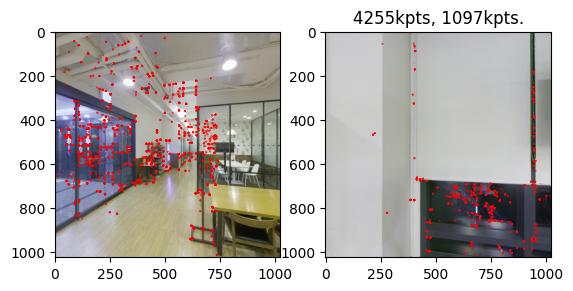

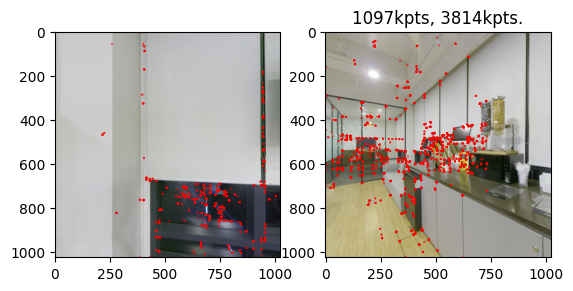

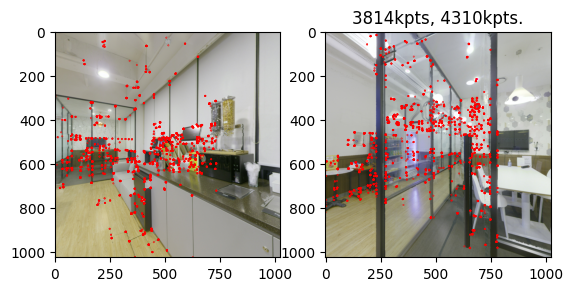

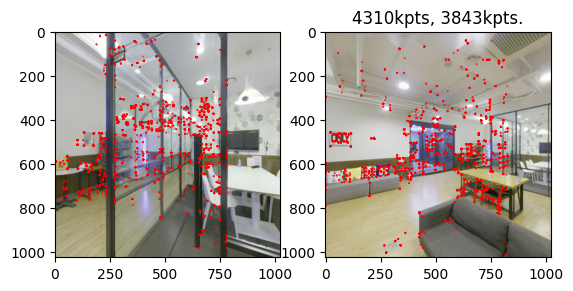

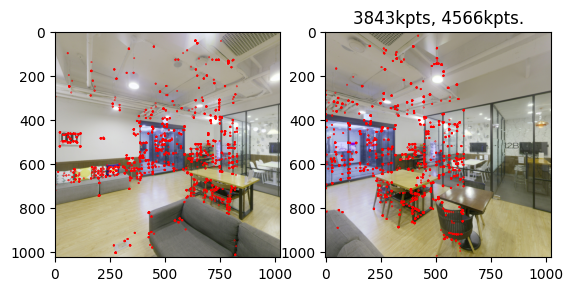

In [20]:
figpath = 'figures/checkdb/'
namelst = list(RTfile.keys())
if not os.path.isdir(figpath):
    os.mkdir(figpath)
    
N = 10
srtidx = 99  # 4 이상
for idx in range(srtidx, len(namelst), 2):
    k = namelst[idx]
    k2 = namelst[idx+2]
    ipath = k.split('2D')[0]
    ipath2 = k2.split('2D')[0]
    name=f"{figpath}_{len(os.listdir(figpath))+1}"
    visualize_kpts(ipath, ipath2, torch.Tensor(RTfile[k]), torch.Tensor(RTfile[k2]),
                           name=name)

    if idx > N:
        break